# Solving 2D heat equation using PINN (PyTorch)

<img src="../images/2D_heat_eq.png" width="35%">

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns

## Define the PINN network

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

## Functions for creating a data points (IC, BC)

In [3]:
def initial_condition(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

def boundary_condition(x, y, t, custom_value):
    return torch.full_like(x, custom_value)

In [4]:
# generate collocation points
def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad=True)  # torch.rand generate values interval [0, 1]
    y = torch.rand(num_points, 1, requires_grad=True)
    t = torch.rand(num_points, 1, requires_grad=True)
    return x, y, t

In [5]:
# generate boundary points
def generate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0, 1.0]).repeat(num_points // 2) # generate BC for left and right side
    y_boundary = torch.rand(num_points) 

    if torch.rand(1) > 0.5:  # it can be changed to the bottom and up BC
        x_boundary, y_boundary = y_boundary, x_boundary
    
    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)


def generate_boundary_training_data(num_points):
    x_boundary, y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points, 1, requires_grad=True)  # ?

    return x_boundary, y_boundary, t

In [ ]:
# def generate_boundary_points(num_points):
#     # Points on vertical boundaries x = 0 and x = 1
#     num_points_per_side = num_points // 4
    
#     x_left = torch.zeros(num_points_per_side)
#     y_left = torch.rand(num_points_per_side)
    
#     x_right = torch.ones(num_points_per_side)
#     y_right = torch.rand(num_points_per_side)
    
#     # Points on horizontal boundaries y = 0 and y = 1
#     y_bottom = torch.zeros(num_points_per_side)
#     x_bottom = torch.rand(num_points_per_side)
    
#     y_top = torch.ones(num_points_per_side)
#     x_top = torch.rand(num_points_per_side)
    
#     # Combine all boundary points
#     x_boundary = torch.cat((x_left, x_right, x_bottom, x_top))
#     y_boundary = torch.cat((y_left, y_right, y_bottom, y_top))
    
#     return x_boundary.view(-1, 1), y_boundary.view(-1, 1)

# # Example usage
# num_points = 100
# x_boundary, y_boundary = generate_boundary_points(num_points)
# print(x_boundary, y_boundary)

## Define the residual of equation

In [7]:
def pde(x, y, t, model):
    input_data = torch.cat([x, y, t], dim = 1)
    u = model(input_data)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    diff_coeff = 1
    residual = diff_coeff * (u_xx + u_yy) - u_t
    return residual 


## Training

In [8]:
def train_pinn(model, num_iterations, num_points):
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        x, y, t = generate_training_data(num_points)

        x_b, y_b, t_b = generate_boundary_training_data(num_points)

        t_initial = torch.zeros_like(t)
        u_initial = initial_condition(x, y)

        custom_value = 0
        u_boundary_x = boundary_condition(x_b, y_b, t_b, custom_value)
        u_boundary_y = boundary_condition(y_b, x_b, t_b, custom_value)
        
        residual = pde(x, y, t, model)
        
        loss_func  = nn.MSELoss()
        
        u_pred_init = model(torch.cat([x, y, t_initial], dim=1))
        u_pred_bc_x = model(torch.cat([x_b, y_b, t_b], dim=1))
        u_pred_bc_y = model(torch.cat([y_b, x_b, t_b], dim=1))  # just flipped x_b and y_b, then bc changed
        
        loss_init = loss_func(u_initial, u_pred_init)
        loss_bc1 = loss_func(u_boundary_x, u_pred_bc_x)
        loss_bc2 = loss_func(u_boundary_y, u_pred_bc_y)
        loss_residual = loss_func(residual, torch.zeros_like(residual))
        
        loss = loss_init + loss_bc1 + loss_bc2 + loss_residual

        loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print("iteration", iteration, "loss", loss)
            #print(f'Iteration: {iteration} | loss = {loss}')    

In [9]:
model = PINN()
num_iterations = 10000
num_points = 1000
train_pinn(model, num_iterations, num_points)

iteration 0 loss tensor(0.2199, grad_fn=<AddBackward0>)
iteration 100 loss tensor(0.1208, grad_fn=<AddBackward0>)
iteration 200 loss tensor(0.1144, grad_fn=<AddBackward0>)
iteration 300 loss tensor(0.1043, grad_fn=<AddBackward0>)
iteration 400 loss tensor(0.0876, grad_fn=<AddBackward0>)
iteration 500 loss tensor(0.0829, grad_fn=<AddBackward0>)
iteration 600 loss tensor(0.0752, grad_fn=<AddBackward0>)
iteration 700 loss tensor(0.0686, grad_fn=<AddBackward0>)
iteration 800 loss tensor(0.0651, grad_fn=<AddBackward0>)
iteration 900 loss tensor(0.0617, grad_fn=<AddBackward0>)
iteration 1000 loss tensor(0.0573, grad_fn=<AddBackward0>)
iteration 1100 loss tensor(0.0500, grad_fn=<AddBackward0>)
iteration 1200 loss tensor(0.0480, grad_fn=<AddBackward0>)
iteration 1300 loss tensor(0.0468, grad_fn=<AddBackward0>)
iteration 1400 loss tensor(0.0414, grad_fn=<AddBackward0>)
iteration 1500 loss tensor(0.0366, grad_fn=<AddBackward0>)
iteration 1600 loss tensor(0.0351, grad_fn=<AddBackward0>)
iteration

## Results evaluation (Visaulization)

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


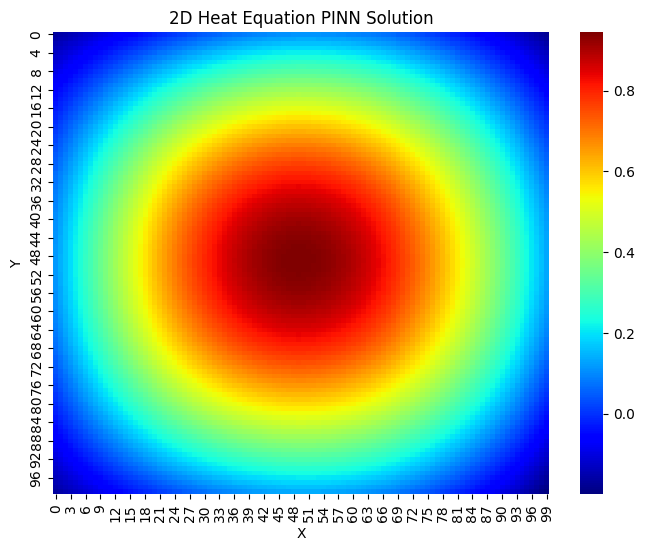

In [15]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0 # specify the time, 0 can be changed depending what time prediciton you want to see
    print(X.shape, Y.shape, t_val.shape)

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize = (8, 6))
    sns.heatmap(solution, cmap='jet')
    plt.title("2D Heat Equation PINN Solution")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


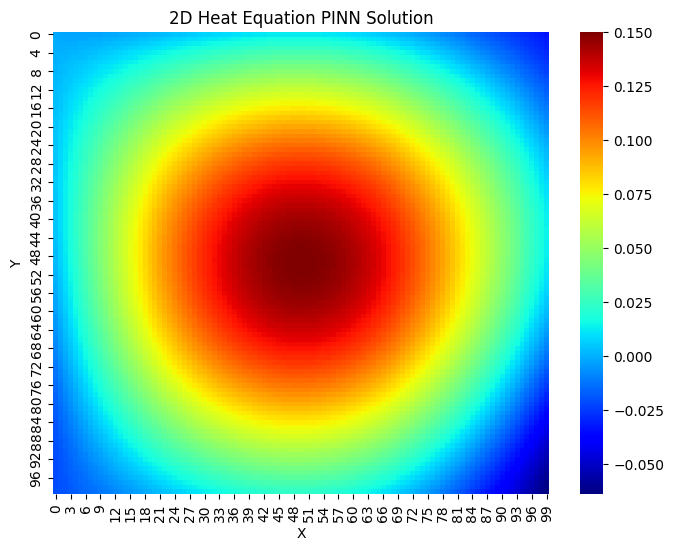

In [18]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0.1 # specify the time, 0 can be changed depending what time prediciton you want to see
    print(X.shape, Y.shape, t_val.shape)

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize = (8, 6))
    sns.heatmap(solution, cmap='jet')
    plt.title("2D Heat Equation PINN Solution")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


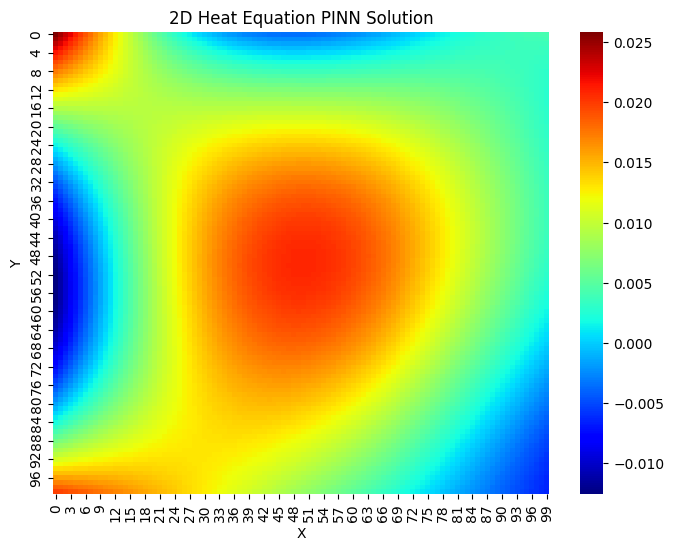

In [21]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0.2 # specify the time, 0 can be changed depending what time prediciton you want to see
    print(X.shape, Y.shape, t_val.shape)

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize = (8, 6))
    sns.heatmap(solution, cmap='jet')
    plt.title("2D Heat Equation PINN Solution")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


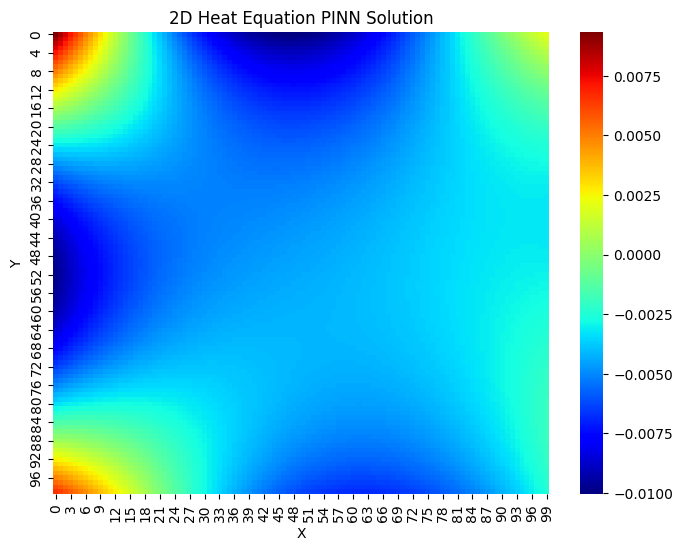

In [22]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0.5 # specify the time, 0 can be changed depending what time prediciton you want to see
    print(X.shape, Y.shape, t_val.shape)

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize = (8, 6))
    sns.heatmap(solution, cmap='jet')
    plt.title("2D Heat Equation PINN Solution")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


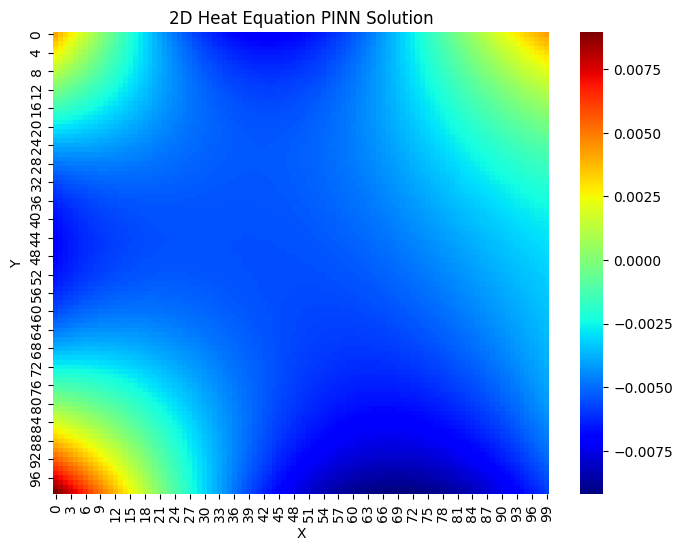

In [23]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0.75 # specify the time, 0 can be changed depending what time prediciton you want to see
    print(X.shape, Y.shape, t_val.shape)

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize = (8, 6))
    sns.heatmap(solution, cmap='jet')
    plt.title("2D Heat Equation PINN Solution")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

torch.Size([100, 100]) torch.Size([100, 100]) torch.Size([100, 100])


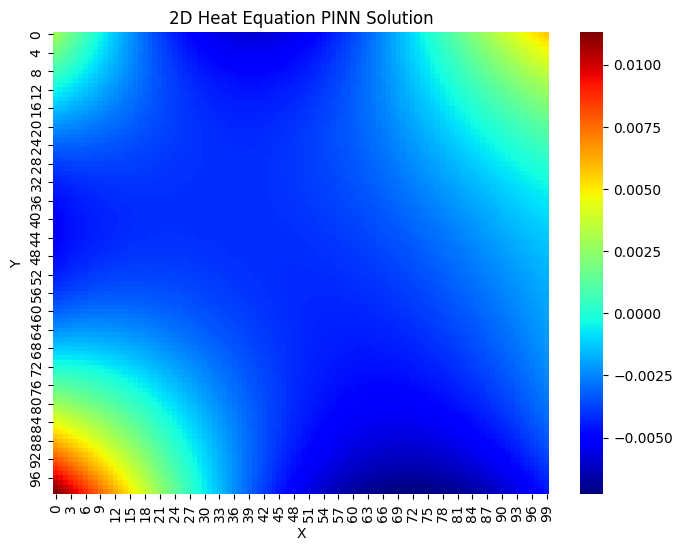

In [40]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)
    t_val = torch.ones_like(X) * 0.9 # specify the time, 0 can be changed depending what time prediciton you want to see
    print(X.shape, Y.shape, t_val.shape)

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize = (8, 6))
    sns.heatmap(solution, cmap='jet')
    plt.title("2D Heat Equation PINN Solution")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [62]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# import seaborn as sns
# import torch

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 100  
# plt.rcParams['animation.embed_limit'] = 50.0  # Set the limit to 50 MB
# plt.ioff()

# # Define the function to generate the solution at a specific time step
# def generate_solution_at_time(t, model, X, Y):
#     t_val = torch.ones_like(X) * t
#     input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
#     solution = model(input_data).reshape(X.shape, Y.shape)
#     return solution.detach().cpu().numpy()  # Use detach() and convert to numpy array

# # Initialize the spatial grid
# x_vals = torch.linspace(0, 1, 100)
# y_vals = torch.linspace(0, 1, 100)
# X, Y = torch.meshgrid(x_vals, y_vals)

# # Create a figure for the animation
# fig, ax = plt.subplots(figsize=(8, 6))
# initial_solution = generate_solution_at_time(0, model, X, Y)
# cax = ax.imshow(initial_solution, cmap='jet', origin='lower')
# fig.colorbar(cax)
# ax.set_title('2D Heat Equation PINN Solution at Time Step 0')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')

# # Update function for animation
# def update(frame):
#     t = frame / 100  # Map frame to time
#     solution = generate_solution_at_time(t, model, X, Y)
#     cax.set_data(solution)
#     cax.set_clim(vmin=solution.min(), vmax=solution.max())  # Update color limits based on current solution
#     ax.set_title(f'2D Heat Equation PINN Solution at Time Step {t}')
#     return cax,

# # Create the animation
# ani = FuncAnimation(fig, update, frames=range(100), interval=70)

# # Display the animation
# ani


In [63]:
# ani.save('2D_heat_eq_pinn_solution.gif', writer='pillow', fps=60)